In [143]:
# %matplotlib notebook
# %pylab

In [144]:
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

### Generating the 2D Data

In [145]:
import pickle
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib.animation import FuncAnimation
import pandas as pd
import math
from mpl_toolkits.mplot3d import Axes3D
import itertools

### Experiment Function

In [146]:
STEP ='STEP'
EPISODE = 'EPISODE'
QUADRATIC='QUADRATIC'
COSINE ='COSINE'
CURRENT='CURRENT'# reward in state
DELAYED='DELAYED' # discounted future reward
CURRENT_DELAYED ='CURRENT_DELAYED' # current reward + discounted future reward

In [147]:
from experiment import *
name = "LimitedJump_1000_1DQ"
parameters={
            "exp": name,            #name of experiment
            "mode": EPISODE,           # two modes of execution, 1 episode(1000steps) or N episodes -[step, episode] 
            "data_dimension": 2,    # dimension of data, 1 to N Dimension
            "function":QUADRATIC,   # quadratic or cosine
            "queue_length": 5,      # max length of queue
            "heuristic_queue":2,    # sequeuce length that is considered by the heuristic
            "discount_factor": 0.9, # discount factor               
            "max_skip":7,           # maximum allowed skip 
            "e_start": 1,           # episilon value to start applying heuristic
            "e_stop":0.1,             # episilon value to stop applying heuristic
            "epi": 100,             # number of episodes
            "learning_rate": 0.9,   # learning rate
            "reward":CURRENT,       # current/delayed/current_delayed
            "lambda":0.038,
            "min_skip":3, 
            "baseline":True,        # parameter to switch to baseline model(without heuristic)
            "num_step":1000
        }

create_experiment(parameters)

In [148]:
exp = view_experiment(name)

In [149]:
def styblinski_tang(x):
    """
    compute styblinski-tang optimization test function

    Args:
        x(array): array to compute the styblinki_tang value of

    Returs:
        the evaluated value of styblinki_tang function of x
    """
    result = x**4 - 16 * x**2 + 5 * x
    return result / 2



def rosenbrock(x):
    """
    Compute Rosenbrock test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of rosenbrock function of x
    """
    #print(x)
    #result = np.sum(100.0 * (x[1:] - x[:-1]**2.0) ** 2.0 + (1 - x[:-1])**2.0, axis=0)
    result = 100*(x[1]-x[0]**2)**2 + (x[0]-1)**2
    return result


def quadratic(x):
    """
    Compute quadratic test function for a single point

    Args:
        x(array): array to compute the rosenbrock value of

    Returs:
        the evaluated value of quadratic function of x
    """
    result = np.sum(0.3*x**2 -5, axis=0)

    return result

def camelback(x):
    #print(x)
    return ((4-2.1*x[0]**2 + (x[0]**4)/3)*x[0]**2 + x[0]*x[1] + (-4+4*(x[1]**2))*x[1]**2)

def griewank(x):
    return (x[0]**2)/4000+(x[1]**2)/4000 - np.cos(x[0])-np.cos(x[1]/2)+1

def eason(x):
    return -np.cos(x[0])*np.cos(x[1])*np.exp(-(x[0]-np.pi)**2-(x[1]-np.pi)**2)

def egg_holder(x):
    return -(x[1]+47)*np.sin(np.sqrt(abs(x[1]**2 + x[0]/2 + 47))) - x[0]*np.sin(np.sqrt(abs(x[0]-(x[1]+47))))
    
def array_map(f, x):
    return np.array(list(map(f, x)))

def quadratic_2d(x):
    A = np.matrix([[1, 0],[0, 2]])
    b = np.matrix([[0],[0]])
    c = 0
    return float(0.5 * x.T * A * x - b.T * x + c)

In [150]:
def bowl(f):
    fig = plt.figure(figsize=(10,8))
    qf = fig.gca(projection='3d')
    data = 5
    x1 = list(np.arange(-data,data+1, 1))
    x2 = list(np.arange(-data,data+1, 1))
    size = len(x1)
    x1, x2 = np.meshgrid(x1, x2)
    zs = np.zeros((size, size))
    collector = []
    value = []
    for i in range(size):
        for j in range(size):
            x = np.matrix([[x1[i,j]], [x2[i,j]]])
            collector.append([x1[i,j], x2[i,j]])
            zs[i,j] = f(x)
            value .append(zs[i,j])
    qf.plot_surface(x1, x2, zs, rstride=1, cstride=1, linewidth=0)
    fig.show()
    return x1, x2, zs, collector, value

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


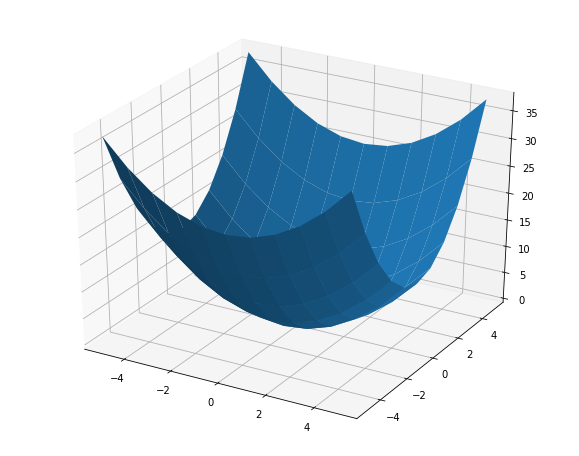

In [151]:
x1, x2, data, collector, value = bowl(quadratic_2d)

/home_nfs/djanden/ioi/exp/iopa/libiopa/experiment_design/work/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


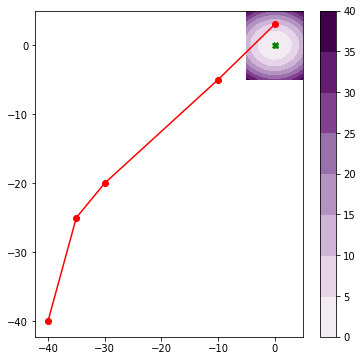

In [152]:
from matplotlib import cm

def contoursteps(x1, x2, zs, steps=None):
    fig = plt.figure(figsize=(6,6))
    levels = np.arange(-2.0, 1.601, 0.4)
    norm = cm.colors.Normalize(vmax=abs(zs).max(), vmin=-abs(zs).max())
    cmap = cm.PRGn
    cmap=cm.get_cmap(cmap, len(levels) - 1)
    cp = plt.contourf(x1, x2, zs, norm = norm, cmap=cmap.reversed())
    plt.plot(0, 0, 'X', color='green')
    fig.colorbar(cp)
    #plt.clabel(cp, inline=1, fontsize=10)
    if steps is not None:
        step =steps
        steps = np.matrix(steps)
        plt.plot(steps[:,0], steps[:,1], '-o', color='red')
#     for i, txt in enumerate(len(step)):
#         fig.annotate(value, (z[i], y[i]))
    fig.show()
    
steps = [(-40,-40),(-35,-25), (-30,-20),(-10,-5),(0,3)]
contoursteps(x1, x2, data, steps)

In [153]:
data_df = pd.DataFrame({"collector":collector,"duration":value})


In [154]:
data_df.tail()

,collector,duration
116,"[1, 5]",25.5
117,"[2, 5]",27.0
118,"[3, 5]",29.5
119,"[4, 5]",33.0
120,"[5, 5]",37.5


### Utilities

In [155]:
def action_space(dim, max_skip=7):

    length = 2 * max_skip * dim +1
    res = np.zeros((length, dim))
    j=1
    for i in range(0, dim):
        for skip in range(1, max_skip+1):
            res[j][i]= -skip
            j+=1
            res[j][i]=skip
            j+=1
    if dim==1:
        res1 = [ x[0] for x in res ]
        res = res1[:]
        return res
        
    return res.astype(int).tolist()

In [156]:
action_space(exp['data_dimension'], exp['max_skip'])

[[0, 0],
 [-1, 0],
 [1, 0],
 [-2, 0],
 [2, 0],
 [-3, 0],
 [3, 0],
 [-4, 0],
 [4, 0],
 [-5, 0],
 [5, 0],
 [-6, 0],
 [6, 0],
 [-7, 0],
 [7, 0],
 [0, -1],
 [0, 1],
 [0, -2],
 [0, 2],
 [0, -3],
 [0, 3],
 [0, -4],
 [0, 4],
 [0, -5],
 [0, 5],
 [0, -6],
 [0, 6],
 [0, -7],
 [0, 7]]

### Sum Tree

In [157]:
import numpy

class SumTree:
    write = 0

    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = numpy.zeros( 2*capacity - 1 )
        self.data = numpy.zeros( capacity, dtype=object )

    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, p, data):
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])

In [158]:
import random

class MemoryISPER:   # stored as ( s, a, r, s_ ) in SumTree


    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.e = 0.01
        self.a = 0.6
        self.PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
        self.PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
        self.PER_b = 0.4  # importance-sampling, from initial value increasing to 1

        self.PER_b_increment_per_sampling = 0.001
        self.absolute_error_upper = 1.

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, sample):
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])

        if max_priority == 0:
            max_priority = self.absolute_error_upper

        self.tree.add(self._getPriority(max_priority), sample) 

    def sample(self, n):
        batch = []
        # calculate priority segment
        segment = self.tree.total() / n
        #print('samp', self.tree.total(), n)
        #b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n,), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        #priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total()
        #print('pmin', p_min)
        if p_min ==0:
            p_min =0.001
        max_weight = (p_min * n) ** (-self.PER_b)
          
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)

            sampling_probabilities = p / self.tree.total()
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            is_weights = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   

            batch.append( (idx, data, is_weights) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

In [159]:
import random

class MemoryPER:   # stored as ( s, a, r, s_ ) in SumTree


    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.e = 0.01
        self.a = 0.6

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        p = self._getPriority(error)
        self.tree.add(p, sample) 

    def sample(self, n):
        batch = []
        segment = self.tree.total() / n

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        p = self._getPriority(error)
        self.tree.update(idx, p)

# Reinforcement learning notebook

In [160]:
# from libiopa.jobmodel import databuilder
# from libiopa.tools import dbconnector
# import pandas as pd

# collections = dbconnector.connect('lima16',27017,'cmdb_database','JobItem','FileIOSummary')
# dict_db = dbconnector.load_collections(collections)

In [161]:
# from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import RBF, WhiteKernel
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# from sklearn.preprocessing import MinMaxScaler

In [162]:
class Job:
    def __init__(self, data):
        self.runs = data
        self.preparationRuns()
        
    def preparationRuns(self):
        
        min_dur = min(self.runs['duration'])
        max_dur = max(self.runs['duration'])
        self.runs['durationNorm'] = (self.runs['duration']-min_dur)/(max_dur-min_dur)


    def getStateAndRewardById(self, run_id):

        state = self.runs.T[run_id]
        
        
        return (state['collector'], 1/(state['durationNorm']+0.02))

job1 = Job(data_df)

### Exponential Function

In [163]:
import math
class LinearDecaySchedule(object):
    def __init__(self, initial_value, final_value, max_steps):
        assert initial_value > final_value, "initial_value should be > final_value"
        self.initial_value = initial_value
        self.final_value = final_value
        self.decay_factor = (initial_value - final_value) / max_steps

    def __call__(self, step_num):
        current_value = self.final_value + math.exp(-exp['lambda'] * step_num)
        if current_value < self.final_value:
            current_value = self.final_value
        return current_value

100


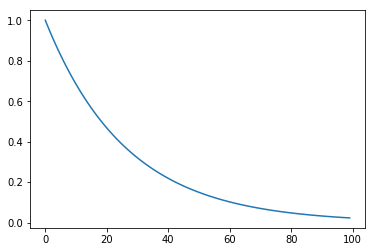

In [164]:
epsilon_initial = 1.0
epsilon_final = 0.
MAX_NUM_EPISODES = exp['epi']
print(MAX_NUM_EPISODES)
MAX_STEPS_PER_EPISODE = 50
linear_sched = LinearDecaySchedule(initial_value = epsilon_initial,
                                final_value = epsilon_final,
                                max_steps = MAX_NUM_EPISODES )
epsilon = [linear_sched(step) for step in range(MAX_NUM_EPISODES )]
plt.plot(epsilon)
plt.show()

In [165]:
linear_sched(300)

1.119548484259094e-05

### Heuristic Function

In [166]:
def get_direction(start, end):
    #convert to numpy arrays
    start = np.array(start)
    end=np.array(end)
    
    # find the vector
    v = start - end
    
    if v[0]!=0:
        if v[0]> 0:
            return 2
        else:
            return 1
    elif v[1]!=0:
        if v[1]>0:
            return 3
        else:
            return 4
    else:
        return 0
    
    
get_direction([2,3],[1,3])

2

In [167]:
def heuristic_weight1(queue_list, n, clip=1000):
    if len(queue_list)==5:
        last_3 = queue_list[-n:]
        deltas =[]
        value_deltas=[]
        min_skip = exp['min_skip']
        # check whether succesive actions are given an increased reward
        for i in range(n-1):
            delta = last_3[i][1]< last_3[i+1][1]
            value_delta = last_3[i+1][1] - last_3[i][1]
            deltas.append(delta)
            value_deltas.append(value_delta)
        if all(deltas):
            # get all 3 successive actions
            all_states = []
            for a in range(len(queue_list)):
                all_states.append(queue_list[a][0])
            all_states= all_states[-n:]
            last_value_delta = value_deltas[-1]
            action_skip = np.round((1+last_value_delta)*min_skip)
            
            if action_skip>clip:
                action_skip=clip
            #print(all_states,get_direction(all_states[0],all_states[1]), action_skip)
            
            return get_direction(all_states[1], all_states[0]), action_skip
        else:
            return -1, -1
    else:
        return -1,-1

In [168]:
def get_inter_states(start, end):
    '''This function assumes that the state change in one dimension 
    only'''
    assert len(start)== len(end)
    
    if np.array_equal(start, end):
        return [start, end]
    dim = len(start)
    start_a = np.array(start)
    end_a = np.array(end)
    vector = end_a - start_a
    dim_change = [i for i, elem in enumerate(vector) if elem!=0][0]

    result =[]
    result.append(start_a)
    last = result[-1]
    sign = -1 if end[dim_change] < start[dim_change] else 1
    
    st = list(range(start[dim_change], end[dim_change]+sign, sign))
    final_states=[]
    for x in st:
        b=np.zeros(shape=(1, dim))
        for i in range(0, dim):
            if i!= dim_change:
                b[0][i] = start[i]
        b[0][dim_change] = x    
        final_states.append(list(b[0]))
    return final_states

    
        
        
        
get_inter_states([0,0], [0,4])

[[0.0, 0.0], [0.0, 1.0], [0.0, 2.0], [0.0, 3.0], [0.0, 4.0]]

### Environment

In [169]:
# TOOLS

def isin2D(a, b):
    """
        Check the existance of elements of a in b
        return an array : a boolean for each element of a
    """
    boolArray = []
    for i in a:
        present = False
        j = 0
        while present == False and j < len(b):

            if np.array_equal(i, b[j]):
                present = True
            j += 1
        boolArray.append(present)
    return boolArray

In [170]:
from collections import deque
from collections import defaultdict

class Environment:
    def __init__(self, Job):
        self.job = Job

        self.state = None
        self.reward = None
        self.done = False
        self.actions = action_space(exp['data_dimension'], exp['max_skip'])
        #print(self.actions)
        self.def_actions()
        self.d = deque([], maxlen=exp['queue_length'])
        self.reset_env()
        self.valid_actions =defaultdict(list)
        self.actions_possible()
        

    def def_actions(self):
        """
            Define all combinations possibles with 3 numbers in {-2,0,2}
            Creates the list in self.actions
        """
#         self.actions=[
#             [0,0],
#             [-1,0],
#             [1,0],
#             [0,1],
#             [0,-1]
#         ]
        
        return self.actions

    def check_if_action_possible(self, a):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
#         return np.arange(len(self.actions))
        result_actions = [np.add(self.state, a) ]
        possible = isin2D(result_actions, np.array(self.job.runs['collector']))
        #print(possible)
        return possible[0]
    
    def actions_possible(self):
        # get all states
        states = self.list_states()
        for state in states:
            # set state as the current state
            self.set_state(state)
            # save all actions possible
            self.valid_actions[str(state)] = self.check_actions_possible1()

        
    def get_reward(self, state):
        reward = -1000
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], state):
                state, reward = self.job.getStateAndRewardById(r)
        return reward
    
    def check_actions_possible1(self):
        """
            For each action, check if it is possible to apply to the current state :
            apply the action on the currect state and check if the new state is defined
            in the run dataFrame !!!!!! WILL BE CHANGED !!!
        """
        result_actions = [np.add(self.state, a) for a in self.actions]
        possible = isin2D(result_actions, np.array(
            self.job.runs['collector']))

        return np.where(np.array(possible) == True)[0]
    
    def check_actions_possible(self):
        return self.valid_actions[str(self.state)]

    def do_action(self, action_id, esp=1, verbose = False, train=True):
        """
            Apply the action defined by action_id.
            Changes the current_state
            Returns (new_state,reward of the action, Done boolean, debug info)
        """
        if not action_id in self.check_actions_possible():
            #print('Something terribly wrong , State {} , Action_id {} '.format(self.state, action_id))
            return (None, -1000, False, {}, action_id)

        params_actual = self.state
        action = self.actions[action_id]
        new_action = action
        action_weight = 1
        if esp <=exp['e_start'] and train==True and exp['baseline']==False:
            queue_list = list(self.d)
            new_action_id, action_weight=heuristic_weight1(queue_list, exp['heuristic_queue'], exp['max_skip'])
            
            if new_action_id != -1:
                new_action = self.actions[new_action_id]
                status= self.check_if_action_possible(np.array(new_action)*action_weight)
                if status == False:
                    action_weight = 1
                    new_action = action
                else:
                    action_id=new_action_id
                
         
            else:
                new_action = action
                action_weight=1
                
        if esp<=exp['e_stop'] and exp['baseline']==False:# stop applying the heuristic
            new_action = action
            action_weight=1

        new_params = np.add(params_actual, (np.array(new_action)*action_weight))
        for r in self.job.runs.T:
            if np.array_equal(self.job.runs['collector'][r], new_params):
                self.state, self.reward = self.job.getStateAndRewardById(r)
                if verbose:
                    print("New state : {0} {1} duration {2}".format(r,self.state,self.job.runs['duration'][r]))
                return (self.state, self.reward, self.decide_done(action_id), {}, action_id)

        raise Exception('Pas normal pour le moment !!!')
        return None
    
    def reset_env(self):
        """ Initialize the environment to a random job """
        run_id = np.random.choice(self.job.runs.T.keys())
        self.state, self.reward = self.job.getStateAndRewardById(run_id)
        
        self.previous_action = None
        self.nb_actions = 0
        
        return self.state
    
    def set_state(self,state):
        self.reset_env()
        self.state = state
        return state
    
    def decide_done(self,a):
        """
            Decide when the environment is done:
            - no convergence : more than 50 actions since reset
            - stay on the same state more than twice            
        """
        
        self.nb_actions+=1
        action = self.actions[a]
        if exp['mode']==EPISODE:
            done = self.nb_actions > 50
        else:
            done = self.nb_actions > int(exp['num_step'])
        return done
    
    def list_states(self):
        params = np.array(self.job.runs['collector'])
        return params
        

env = Environment(job1)

In [171]:
print(env.reset_env())

env.check_actions_possible()

[-3, 5]


array([ 0,  1,  2,  3,  4,  6,  8, 10, 12, 14, 15, 17, 19, 21, 23, 25, 27])

In [172]:
env.actions

[[0, 0],
 [-1, 0],
 [1, 0],
 [-2, 0],
 [2, 0],
 [-3, 0],
 [3, 0],
 [-4, 0],
 [4, 0],
 [-5, 0],
 [5, 0],
 [-6, 0],
 [6, 0],
 [-7, 0],
 [7, 0],
 [0, -1],
 [0, 1],
 [0, -2],
 [0, 2],
 [0, -3],
 [0, 3],
 [0, -4],
 [0, 4],
 [0, -5],
 [0, 5],
 [0, -6],
 [0, 6],
 [0, -7],
 [0, 7]]

In [173]:
import keras
from keras.models import Model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Masking, CuDNNLSTM, Dropout, Activation, Input, Concatenate

In [174]:
from keras import backend as K
import tensorflow as tf
from keras.optimizers import Adam
# # allocate only a part of the GPU
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.05
# config.log_device_placement = True
# config.allow_soft_placement = True
# sess = tf.Session(config=config)
# K.set_session(sess)

# Deep Q learning

In [175]:

class Brain:
    """
        Brain used by the deep Q learning.
        Defines:
            - the keras model
            - methods to train it
            - methods to predict
    """

    def __init__(self, nb_params, nb_actions):
        """
            Initializes the model

            Args:
                nb_params : number of parameters
                nb_actions : number of actions per state
        """
        self.nb_params = nb_params
        self.nb_actions = nb_actions
        self.model = self.def_model()

    def def_model(self):
        """
            Creates of the keras model and compile it

            Returns:
                Keras model
        """
        params = Input(shape=(2,))

        params_part = Dense(32)(params)
        params_part = Dense(32)(params_part)
        #params_part = Dense(32)(params_part)
        #params_part = Dense(10)(params_part)

        out = Dense(self.nb_actions)(params_part)

        model = Model(inputs=[params], outputs=[out])
        #model.compile(optimizer='RMSprop', loss='mse', metrics=['mae'])
        adam = Adam(lr=exp['learning_rate'], beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        model.compile(optimizer=adam, loss='mse', metrics=['mae'],)
        return model

    def fit_batch(self, states, vectors, batch_size, epochs=1, verbose=0):
        """
            Fit the model with the given states and Q vectors

            Args:
                states : list of states
                vectors : 1 vector per state
                batch_size : batch_size used during training
                epochs : Number of training epochs [default=1]
                verbose : verbose level of the Keras training [default=0]

            Returns:
                history of the training (defined in Keras)
        """
        # to be sure that the input is an array of array
        params = np.array([np.array(x) for x in states])
        vectors = np.array(vectors)
        return self.model.fit(params, vectors, epochs=epochs, batch_size=batch_size,
                              verbose=verbose)

    def predict(self, states, batch_size=1):
        """
            Predict the vector for a given list of states

            Args:
                states : list of states
                batch_size : batch size used by the model to predict [default=1]

            Returns:
                Array of predicted Q vectors (1 per state)
        """
        #
        #print(states.shape)
        # to be sure that the input is an array of array
        params = np.array([np.array(x) for x in states])
        #print(params.shape, params)
        return self.model.predict(params, batch_size)

    def predict_batch(self, states):
        """
            Predict the Q vector for a given list of states

            Args:
                states : array of states

            Returns:
                matrix of shape (nb states, nb actions) containing the q values predicted by the
                    neural network
        """
        return self.model.predict(states, batch_size=len(states))


In [176]:
import time

In [177]:
class Memory:
    """
        Memory class used by the deep agent during learning.
        The memory is a queue of fixed length to save a the transitions done by the agent :
        (cuurent_state, action taken, obtained reward, next state, environment done)
        It allows to :
            - add a new transition
            - get a set of random transitions
            - store the actions taken in each state
            - store the optimum state
    """

    def __init__(self, capacity, nb_actions):
        """
            Initializes the empty memory

            Args :
                capacity: Max number of transitions stored
                nb_actions: number of possible actions in each state
        """
        self.capacity = capacity
        self.nb_actions = nb_actions
        self.memory = list()

        self.memory_actions = dict()  # dict of arrays indexed by the actions
        self.memory_best = list()  # contains the list action 0 of the best states

    def append(self, state, action, reward, next_state, done):
        """
            Adds a new transition into the memory

            Args:
                state (array)
                action (integer 0<=action<nb_actions)
                reward (float)
                next_state (array)
                done (boolean)
        """
        # remove the first element of the memory if full
        if len(self.memory) > self.capacity:
            self.pop()

        self.memory.append((state, action, reward, next_state, done))

        # append in memory_actions dict
        state = np.array(state)
        # to index the dict (tobytes from the numpy lib)
        key_dict = state.tobytes() # an array is unhashable, a better solution need to be found
        if key_dict not in self.memory_actions.keys():
            # for each state : array counting the number of times an action was taken
            self.memory_actions[key_dict] = np.zeros(self.nb_actions)
        self.memory_actions[key_dict][action] += 1

        # new best list: if best empty or if better than known best
        nb_mem_best = len(self.memory_best)
        if nb_mem_best == 0 or self.memory_best[0][2] < reward:
            self.memory_best = list()
            # artifically creates a new transition to stay on the optimum
            self.memory_best.append((next_state, 0, reward, next_state, False))
        # if equal to best reward : append to the list
        elif nb_mem_best > 0 and self.memory_best[0][2] == reward:
            self.memory_best.append((next_state, 0, reward, next_state, False))

    def pop(self):
        """
            Removes the first transition in the memory
        """
        old_elem = self.memory[0]
        state_key = old_elem[0].tobytes()
        action = old_elem[1]
        self.memory.pop(0)
        # remove the action from the dict of actions taken
        self.memory_actions[state_key][action] -= 1

    def sample(self, n_total, n_best):
        """
            Samples randomly elements from the memory (both the transition and the best memory)

            Args :
                n_total : number of sample returned
                n_best : Among the sample returned, number of sample taken from the best memory

            Returns:
                array of transitions
        """
        # select n_total-n_best elements from memory
        idxs = np.random.choice(np.arange(len(self.memory)), size=n_total - n_best)
        mem_samples = np.array(self.memory)[idxs]

        # select n_best elements from best list
        idx_best = np.random.choice(np.arange(len(self.memory_best)), size=n_best)
        mem_best = np.array(self.memory_best)[idx_best]

        # merge the two list
        full = np.append(mem_samples, mem_best, axis=0)
        return full

    def list_actions_for_state(self, state):
        """
            Returns, for a given state, the list of action that were already taken.

            Args :
                state : state in question

            Returns :
                Array of actions index
        """
        state_key = np.array(state).tobytes()
        actions = []
        if state_key in self.memory_actions.keys():
            actions = np.where(self.memory_actions[state_key] > 0)[0]

        return np.array(actions)

       

In [178]:
import time
from time import strftime

In [179]:

class DoubleQAgent:
    """
        DoubleQAgent : Implementation of the double Q learning algorithm to learn the optimal
        parameters. Uses the Memory, Brain, Environment defined in this folder

        Defines :
            - method to train the networks
            - method to take decision given a state
    """

    def __init__(self, env):
        """
            Initializes the agent

            Args:
                env : environment object (defined in Environment.py)
        """
        self.env = env
        self.number_actions = len(env.def_actions())

        self.memory = MemoryPER(10000)

        self.model1 = Brain(2, self.number_actions)
        self.model2 = Brain(2, self.number_actions)  # target net

        # hyperparameters
        self.default_hyperparms = {
            'sample_batch_size': 32,
            'disc_factor': 0.9,
            'max_epsilon': 1,
            'min_epsilon': 0.01,
            'decay_speed': 0.01,
            'update_target_frequency': 100
        }


    def decision(self, state, exploration_rate, possible_actions =[]):
        """
            Epsilon greedy decision

            Ärgs :
                state : state used to decide the action
                exploration_rate : probability of taking a random decision

            Returns :
                action (integer)
        """
        if np.random.random() < exploration_rate:
            # random decision
            #
            if len(possible_actions)==0:
                possible_actions = np.arange(self.number_actions)
            #possible_actions = env.check_actions_possible()
            #print('possible',possible_actions)

            # actions already taken in this state
            #action_done = self.memory.list_actions_for_state(state)
            #print('state', state, 'actions', action_done)
            #set_actions = np.setdiff1d(possible_actions, action_done)  # action never made in state
            #set_actions =[]
            #if set_actions.size == 0:
            set_actions = possible_actions
            #print('state', state, 'actions', action_done, "set", set_actions)
            return np.random.choice(set_actions)
        else:
            # choose the max rewarded action
            values = self.model1.predict(np.array([state]))[0]
            return np.argmax(values)

    def remember(self, state, action, reward, next_state, done, error):
        """
            Add a transition into the memory

            Args :
                state: current_state [metrics, params]
                action : action taken (int)
                reward : reward received after action (float)
                next_state : None if no next state or a state
                done : boolean
        """
        # for now, stores only the parameters
        if next_state is not None:
            next_state = next_state
        self.memory.add(error, (np.array(state), action, reward, next_state, done))
        
    def compute_td_error(self, next_state, reward, action):
        Q_next = self.model1.predict([next_state])[0]
        #print('Q_next', Q_next)
        current = reward +  exp['discount_factor'] * np.max(self.model1.predict([next_state])[0])
        td_error = abs(current - Q_next[action])
        return td_error
    
    def replay(self, batch_size):
        #print('6')
        batch = self.memory.sample(batch_size)
        #print('7')
        x_batch, y_batch, errors = [], [], []
        for i in range(len(batch)):
            #print(batch[i])
            minibatch = batch[i][1]
            #print(minibatch)
            try:
                state = minibatch[0]; action = minibatch[1]
                reward = minibatch[2]; next_state = minibatch[3]; done = minibatch[4]
            except:
                print(batch[i])
            #print('state', state.shape)
            y_target = self.model1.predict([state])
            #print('target',y_target)
            target_init= y_target[0][action]
            y_target[0][action] = reward if done else reward + \
            exp['discount_factor'] * np.max(self.model2.predict([next_state])[0])

            x_batch.append(state)
            y_batch.append(y_target[0])

            td_error = abs(target_init - y_target[0][action])
            #errors.append(td_error*batch[i][2])
            errors.append(td_error)
        
        #updating the priorities of samples
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        #print(x_batch, x_batch.shape)
        self.model1.fit_batch(np.array(x_batch), np.array(y_batch), batch_size=len(x_batch))

    def replay1(self, batch_size, disc_factor):
        """
            Gets a set of samples from the memory.
            From this set, computes the batch to train the max network on :
            - list of states
            - for each state : a vector a Q values

            Args:
                batch_size : batch size to use for training
                disc_factor : discount factor of the update formula
        """
        batch = self.memory.sample(batch_size)

        # create 2 lists of states : source and next from batch
        no_state = np.zeros(2)
        #states1 = np.array([(no_state if i is None else i) for i in batch[:, 0]])
        states1 = np.array([i for i in batch[:,0]])
        states2 = np.array([(no_state if i is None else i) for i in batch[:, 3]])
        #print(states1.shape)
        # Compute the Q values from the target network for the states of the 2 previous list
        p_state1 = self.model2.predict_batch(states1)
        p_state2 = self.model2.predict_batch(states2)

        # Compute the Q values from the max network of the next states
        pmax_state2 = self.model1.predict_batch(states2)

        batch_states = []
        batch_actions = []
        # compute the Q vectors
        for i, (state, action, reward, next_state, _) in enumerate(batch):
            if next_state is None:
                target = reward
            else:
                b_action = np.argmax(pmax_state2[i])
                target = reward + disc_factor * p_state2[i][b_action]

            q_vec = p_state1[i]
            q_vec[action] = target
            batch_states.append(state)
            batch_actions.append(q_vec)

        self.model1.fit_batch(batch_states, batch_actions, batch_size)

    def run(self, start_state, num_episode, hyperparams=None):
        """
            Trains the agent

            Algorithm explained in
            https://confluence.sdmc.ao-srv.com/display/BRDM/Inference+using+Deep+Reinforcement+Learning

            Args:
                start_state : initialize each episde with this state. If None initialize with a
                                random state
                num_episode : number of episode to train the network
                hyperparms : hyperparameters to use Default : hyperparms = {
                                                                'sample_batch_size' : 32,
                                                                'disc_factor' : 0.9,
                                                                'max_epsilon' : 1,
                                                                'min_epsilon' : 0.01,
                                                                'decay_speed' : 0.01,
                                                                'update_target_frequency' : 100
                                                            }

            Returns:
                dict of the training history : {
                    'index_max_reward': for each episode, number of actions to get the optimum
                    state,
                    'states_visited': for each episode, list of visited states
                    'nb_max': for each episode, number of time the env was in the optimum state
                    'sum_rewards': for each episode, sum of reward
                }
        """
        if hyperparams is None:
            hyperparams = self.default_hyperparms
        else:
            hyperparams.update(self.default_hyperparms)

        states_visited = [list() for _ in range(num_episode)]
        index_max = np.ones(num_episode) * 51
        sum_reward = np.zeros(num_episode)
        nb_max = np.zeros(num_episode)

        steps = 0

        for i in range(num_episode):
            if i%2==0:
                print("Episode {0} out of {1}".format(i + 1, num_episode))
            if start_state is None:
                state = self.env.reset_env()
            else:
                state = self.env.set_state(start_state)

            done = False
#             exploration_rate = hyperparams['min_epsilon'] + (hyperparams['max_epsilon'] -
#                                                             hyperparams['min_epsilon']) * \
#                                math.exp(-hyperparams['decay_speed'] * i)
            
            exploration_rate = linear_sched(i)
            states_visited[i].append(state)
            nb_actions = 0
            #j = 1
            while not done:

                valid_actions = self.env.check_actions_possible()
                #print(valid_actions)
                action = self.decision(state, exploration_rate,valid_actions)
       
                steps += 1
                next_state, reward, done, _,_ = self.env.do_action(action)
                
#                 if reward ==-1000:
#                     print("Reward is -1000", valid_actions, action)
                sum_reward[i] += reward

                #print(next_state, state)
                if next_state is not None:
                    states_visited[i].append(state)
                    td_error = self.compute_td_error(next_state, reward, action)
                    #print(td_error)
                    self.remember(state, action, reward, next_state, done, td_error)
                    state = next_state
                if i > 1:
                    self.replay(hyperparams['sample_batch_size'])
                # update the target network
                if steps % hyperparams['update_target_frequency'] == 0:
                    self.model2.model.set_weights(self.model1.model.get_weights())

                nb_actions += 1
                if reward == 50.0 and index_max[i] == 51:
                    index_max[i] = nb_actions
                if reward == 50.0:
                    nb_max[i] += 1

        return {
            'index_max_reward': index_max,
            'states_visited': states_visited,
            'nb_max': nb_max,
            'sum_rewards': sum_reward
        }



In [ ]:
a = DoubleQAgent(env)
states = env.list_states()
t0 = time.time()
res = a.run(start_state=(states[0]), num_episode=exp['epi'],  hyperparams={'batch_size': 32})
t1 = time.time()
print("done {0}".format((t1-t0)/60))

Episode 1 out of 100
Episode 3 out of 100
Episode 5 out of 100
Episode 7 out of 100
Episode 9 out of 100
Episode 11 out of 100
Episode 13 out of 100
Episode 15 out of 100
Episode 17 out of 100
Episode 19 out of 100
Episode 21 out of 100
Episode 23 out of 100
Episode 25 out of 100
Episode 27 out of 100
Episode 29 out of 100
Episode 31 out of 100
Episode 33 out of 100
Episode 35 out of 100
Episode 37 out of 100
Episode 39 out of 100
Episode 41 out of 100


In [ ]:
res['states_visited'][exp['epi']-1]

In [ ]:
res['states_visited'][99]

In [ ]:
for x in range(exp['epi']):
    if len(res['states_visited'][x])<50:
        print(x+1)
        

In [ ]:
contoursteps(x1,x2, data, res['states_visited'][9])

In [ ]:
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def show(epi):
    contoursteps(x1,x2, data, res['states_visited'][epi])

In [ ]:
interact(show,epi=widgets.IntSlider(value=1, min=10, max=299, step=1))

In [ ]:
import pickle
def save_results(filename, data):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    return True
def load_results(filename):
    filename = 'trained_results/'+filename +'.pkl'
    with open(filename, 'rb') as f:
        b = pickle.load(f)
    return b

In [ ]:
#save_results('deep2d_5x5_32_32_new',res)

In [ ]:
#res =load_results('deep2d_5x5_32_32')

In [ ]:
#contoursteps(x1,x2, data, rd['states_visited'][15])

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['index_max_reward']
MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * i) for i in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step to get the optimum with epsilon \nstart : {0} , lambda={1}'.format(states[80],LAMBDA))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['nb_max']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('steps', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Variation of the number of step the agent stayed in the optimum per episode \nstart : {0} '.format(states[0]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
nb = len(res['index_max_reward'])
t = np.arange(nb)
data1 = res['sum_rewards']

MAX_EPSILON = 1
MIN_EPSILON = 0.01
LAMBDA = 0.01 # speed of decay
data2 = [MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * step) for step in range(nb)]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('episode')
ax1.set_ylabel('sum', color=color)
ax1.scatter(t, data1, color=color, s=3)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('epsilon', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax1.set_title('Sum of rewards per episode \nstart : {0} '.format(states[80]))
fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.legend()
plt.show()

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [ ]:
dimFixe = 1 # dimension fixe : 1 for binsize
fixVal = states[1][80][dimFixe]
idx = np.where(np.array([i for i in job1.runs['accelerators']])[:,dimFixe]==fixVal)[0]
accels = [ i for i in np.array(job1.runs['accelerators'])[idx]]
accels = np.delete(accels, dimFixe, 1)

duration = 1/(np.array(job1.runs['durationNorm'])[idx]+0.02)

In [ ]:
def plot(list_episodes,index_episode,all_before=False,indicator='r-'):
    Z = duration.reshape(8, 5)
    fig, ax = plt.subplots()
    c = ax.pcolor(Z)
    fig.colorbar(c, ax=ax)

    if all_before == False:
        episodes = [list_episodes[index_episode]]
    else:
        episodes = np.array(list_episodes)[np.arange(index_episode+1)]
        
    for e in episodes:
        points = np.delete(np.array(e),dimFixe,1)
        ax.plot(points[:,0]/2-0.5,points[:,1]/2,indicator,alpha=0.5*1/len(episodes)+0.2)
    plt.show()

interact(plot, 
         list_episodes=fixed(res['states_visited']), 
         index_episode=widgets.IntSlider(min=0,max=len(res['states_visited'])-1,step=1,value=10),
         indicator = ['r-','r+']
        );

In [ ]:
## 50 Episodes
## liste des états dans list_states
s = np.array(env.set_state((states[0][80], states[1][80])))
list_states = []
list_states.append(s[1])
done = False
while not done:
    action = a.decision(s,0)
    next_s, r, done, _ = env.do_action(action)
    print(r)
    if not next_s is None:
        list_states.append(next_s[1])
    s = next_s
plot([list_states],0,all_before=False)